In [1]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np

from matplotlib import pyplot as plt

import time

import pandas as pd

import urllib.request

from collections import OrderedDict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Model parameters
MASTER_CONFIG = {
    "vocab_size": 65,       # Number of unique characters in the dataset
    "batch_size": 32,       # Number of batches
    "context_window": 16,   # Number of characters in a batch
    "d_model": 128,         # Dimension of linear layers
    "epochs": 10_000,       # Number of training epochs
    "log_interval": 100,    # Frequency of logging the loss in epochs
    "n_heads": 8,           # Number of attention heads
    "n_layers": 4           # Number of Llama layers
}

# Data Preprocessing

In [4]:
# Tiny Shakespeare
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespeare.txt"
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7e635016d1e0>)

In [5]:
# Create vocab list of unique chars
lines = open("tinyshakespeare.txt", 'r').read()
vocab = sorted(list(set(lines)))

In [6]:
# Int to string
itos = {i: ch for i, ch in enumerate(vocab)}

# String to int
stoi = {ch: i for i, ch in enumerate(vocab)}

In [7]:
# Encoding and decoding
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

In [8]:
# Convert dataset into a tensor
dataset = torch.tensor(encode(lines), dtype=torch.int8, device=device)

In [9]:
# Split dataset into train/val/test batches
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
  # Train/val/test split = 0.8/0.1/0.1
  train = data[:int(0.8 * len(data))]
  val = data[int(0.8 * len(data)):int(0.9 * len(data))]
  test = data[int(0.9 * len(data)):]

  # Determine which batch to use
  batch_data = train
  if split == "val":
    batch_data = val
  elif split == "test":
    batch_data = test

  # batch_size number of random starting points in the data
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

  # Input and target sequences
  x = torch.stack([batch_data[i:i + context_window] for i in ix]).long()
  y = torch.stack([batch_data[i + 1:i + context_window + 1] for i in ix]).long()

  return x, y

# Loss

In [10]:
# Computes the mean loss for 10 batches for train/val
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
  out = {}

  # Set the model to evaluation mode
  model.eval()

  # Iterate through train and val splits
  for split in ["train", "val"]:
    losses = []

    # Get 10 sample batches
    for _ in range(10):
      # Input and target sequences
      xb, yb = get_batches(dataset, split, config["batch_size"], config["context_window"])
      # Run the model and calculate the loss
      _, loss = model(xb, yb)
      losses.append(loss.item())

    out[split] = np.mean(losses)

  # Set the model to train mode
  model.train()

  return out

# Llama Model

In [11]:
class RMSNorm(nn.Module):
  def __init__(self, layer_shape, eps=1e-8, bias=False):
    super(RMSNorm, self).__init__()

    # Register a learnable parameter "scale" as a part of the module
    self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

  def forward(self, x):
    # x: (batch, seq_len, d_model)

    # Calculate Frobenius norm: RMS = 1/sqrt(N) * Frobenius norm
    ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5

    # Normalize x with respect to RMS
    raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

    # Scale the normalized tensor using the learnable parameter "scale"
    return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [12]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False, device=device)

    # Loop through each position in the context window
    for position in range(context_window):
      # Loop through each dimension in the embedding
      for i in range(embedding_dim // 2):
        # Calculate the rotation angle based on the position and embedding dimension
        theta = 10_000 ** (-2 * (i - 1) / embedding_dim)
        # Calculate the rotated matrix elements
        m_theta = position * theta
        R[position, 2 * i, 2 * i] = np.cos(m_theta)
        R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
        R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
        R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)

    return R

class RoPEMaskedAttentionHead(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # Linear transformation for query
    self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
    # Linear transformation for key
    self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
    # Linear transformation for value
    self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
    # Obtain rotary matrix for positional embeddings
    self.R = get_rotary_matrix(config['context_window'], config['d_model'])

  def forward(self, x, return_attn_weights=False):
    # x: (batch, seq_len, d_model)
    b, m, d = x.shape

    # Linear transformations for Q, K, and V
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)

    # Rotate Q and K using the RoPE matrix
    q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
    k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

    # Scaled dot-product attention
    activations = F.scaled_dot_product_attention(q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True)

    # Return the attention weights
    if return_attn_weights:
      # Create causal attention mask
      attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
      # Calculate attention weights and add causal mask
      attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
      attn_weights = F.softmax(attn_weights, dim=-1)
      return activations, attn_weights

    return activations

In [13]:
class RoPEMaskedMultiheadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # RoPEMaskedAttentionHead instances as attention heads
    self.heads = nn.ModuleList([RoPEMaskedAttentionHead(config) for _ in range(config["n_heads"])])
    # Linear layer after concatenating the heads
    self.linear = nn.Linear(config["n_heads"] * config["d_model"], config["d_model"])
    # Dropout layer
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    # x: (batch, seq_len, d_model)

    # Process each attention head and concatenate the results
    heads = [h(x) for h in self.heads]
    x = torch.cat(heads, dim=-1)
    # Linear layer
    x = self.linear(x)
    # Dropout layer
    x = self.dropout(x)

    return x

In [14]:
class SwiGLU(nn.Module):
  def __init__(self, size):
    super().__init__()

    # Linear transformation for the gate mechanism
    self.linear_gate = nn.Linear(size, size)
    # Linear transformation for the main branch
    self.linear = nn.Linear(size, size)
    # Randomly init the beta parameter
    self.beta = torch.randn(1, requires_grad=True)

    # Register beta as a learnable parameter
    self.beta = nn.Parameter(torch.ones(1))
    self.register_parameter("beta", self.beta)

  def forward(self, x):
    # Swish-Gated Linear Unit computation
    swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
    # Element-wise multiplication between the gate and main branch
    out = swish_gate * self.linear(x)

    return out

In [15]:
class LlamaBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # RMSNorm layer for pre-normalization
    self.rms = RMSNorm((config["context_window"], config["d_model"]))
    # RoPEMaskedMultiheadAttention layer
    self.attention = RoPEMaskedMultiheadAttention(config)
    # Feedforward layer with SwiGLU activation
    self.feedforward = nn.Sequential(
        nn.Linear(config["d_model"], config["d_model"]),
        SwiGLU(config['d_model'])
    )

  def forward(self, x):
    # Attention block
    x = self.rms(x)
    x = x + self.attention(x)

    # Linear block
    x = self.rms(x)
    x = x + self.feedforward(x)

    return x

In [16]:
class Llama(nn.Module):
  def __init__(self, config=MASTER_CONFIG):
    super().__init__()
    self.config = config

    # Embedding layer to convert character indices to vectors
    self.embedding = nn.Embedding(config["vocab_size"], config["d_model"])
    # Sequential block of n_layers LlamaBlocks
    self.llama_blocks = nn.Sequential(OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])]))
    # Feedforward network for final output
    self.ffn = nn.Sequential(
        nn.Linear(config['d_model'], config['d_model']),
        SwiGLU(config['d_model']),
        nn.Linear(config['d_model'], config['vocab_size']),
    )

    print("# of params:", sum(p.numel() for p in self.parameters()))

  def forward(self, idx, targets=None):
    # Embedding layer converts character indices to vectors
    x = self.embedding(idx)

    # Llama blocks
    x = self.llama_blocks(x)
    # Final feedforward network for output logits
    logits = self.ffn(x)

    # If there are targets, calculate and return the cross entropy loss
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, self.config["vocab_size"]), targets.view(-1))
      return logits, loss

    return logits

In [17]:
# Training loop
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
  losses = []
  start_time = time.time()

  # Iterate through epochs
  for epoch in range(config["epochs"]):
    # Zero out gradients
    optimizer.zero_grad()

    # Get training batches
    xs, ys = get_batches(dataset, "train", config["batch_size"], config["context_window"])
    # Run the model and calculate the loss
    logits, loss = model(xs, targets=ys)
    # Backpropagate the loss
    loss.backward()
    # Step the optimizer
    optimizer.step()

    # If there's a learning rate scheduler, adjust the learning rate
    if scheduler:
      scheduler.step()

    # Log progress
    if epoch % config["log_interval"] == 0:
      # Calculate batch time
      batch_time = time.time() - start_time

      # Evaluate loss
      x = evaluate_loss(model)
      losses += [x]

      # Print progress
      if print_logs:
        print(f"Epoch: {epoch} | Train loss: {x['train']:0.3f} | Val loss: {x['val']:0.3f} | Batch time: {batch_time:0.3f} | ETA (sec): {batch_time * (config['epochs'] - epoch) / config['log_interval']:0.3f}")

      # Reset timer
      start_time = time.time()

      # Print learning rate
      if scheduler:
        print("Learning rate:", scheduler.get_last_lr()[0])

  print("Val loss:", losses[-1]["val"])

  return pd.DataFrame(losses).plot()

# of params: 2370246
Epoch: 0 | Train loss: 4.126 | Val loss: 4.129 | Batch time: 1.646 | ETA (sec): 164.608
Epoch: 100 | Train loss: 2.388 | Val loss: 2.445 | Batch time: 5.788 | ETA (sec): 573.023
Epoch: 200 | Train loss: 2.231 | Val loss: 2.304 | Batch time: 6.782 | ETA (sec): 664.646
Epoch: 300 | Train loss: 2.103 | Val loss: 2.200 | Batch time: 8.922 | ETA (sec): 865.459
Epoch: 400 | Train loss: 2.029 | Val loss: 2.110 | Batch time: 7.373 | ETA (sec): 707.829
Epoch: 500 | Train loss: 2.000 | Val loss: 2.101 | Batch time: 6.041 | ETA (sec): 573.930
Epoch: 600 | Train loss: 1.965 | Val loss: 2.103 | Batch time: 5.208 | ETA (sec): 489.554
Epoch: 700 | Train loss: 1.944 | Val loss: 2.052 | Batch time: 5.509 | ETA (sec): 512.344
Epoch: 800 | Train loss: 1.955 | Val loss: 2.069 | Batch time: 5.083 | ETA (sec): 467.615
Epoch: 900 | Train loss: 1.878 | Val loss: 2.033 | Batch time: 5.759 | ETA (sec): 524.066
Epoch: 1000 | Train loss: 1.886 | Val loss: 1.974 | Batch time: 5.031 | ETA (sec)

<Axes: >

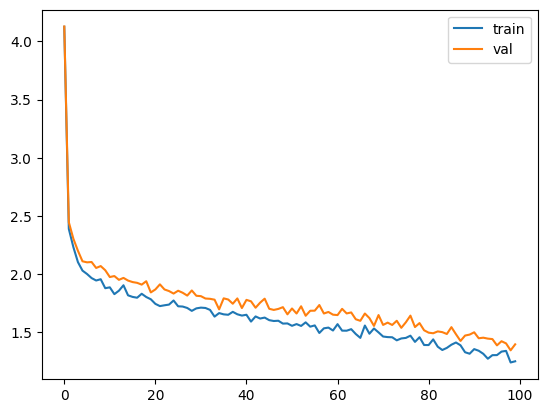

In [18]:
# Reinit model
model = Llama(MASTER_CONFIG).to(device)
# Adam optimizer with specific hyperparameters
llama_optimizer = torch.optim.Adam(
    model.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=1e-3
)
llama_optimizer = torch.optim.AdamW(model.parameters())
# Cosine Annealing learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
scheduler = None

# Train model
train(model, llama_optimizer, scheduler=scheduler, print_logs=True)

In [19]:
# Save the model
torch.save(model, 'llama_model.pth')
# Save the model params
torch.save(model.state_dict(), 'llama_model_params.pth')

# Generating Text

In [20]:
# Generate text using the model
def generate(model, config=MASTER_CONFIG, num_texts=5, max_new_tokens=30):
  # Initialize with zeros = '\n'
  idx = torch.zeros(num_texts, 1, device=device).long()

  for _ in range(max_new_tokens):
    # Call the model
    logits = model(idx[:, -config["context_window"]:])
    # Get the newest logits: [all batches, last time step, all logits]
    last_time_step_logits = logits[:, -1, :]
    # Softmax probabilities
    p = F.softmax(last_time_step_logits, dim=-1)
    # Get the next token from the probabilities
    idx_next = torch.multinomial(p, num_samples=1)
    # Append the token
    idx = torch.cat([idx, idx_next], dim=-1)

  # Return the decoded tokens
  return [decode(x) for x in idx.tolist()]

In [21]:
generate(model, num_texts=1, max_new_tokens=500)

["\nThe terer therel he tilt pet\nyou mies east all take that fool my honour Zays it tongue offtash'd offind a say stuge obls fadies\nit good pilive, that my news, andickled\nYou Like;\nA teak's lo, no let\nI'll nant strath. Would gire your matchs:\nThat shiles many forth to\nneighteil pardon on in trath,Bue tor of\nWith out Richmondings,\nAnd lady you, it,\nAncity, lives, I\nfect see it I tearters to the viatip, spoidesful peck think adammorant;\nSay matter; have hither inloy his unmoltle fulitowarrangim\nThese"]